In [3]:
import sys, os, pickle
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from functions import *
from ode_methods import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [4]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(g=[5.5, 2, 1.1, 1.4, 1.7, 2, 2.3],
                                 dz=[0.03, 0.01, 0.003, 0.001])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [ ]:
for dD in np.arange(0.006, 0.008, 0.0002):
    Delta_0 = solve_for_Delta_0(g=params['g'])
    Delta_0 = Delta_0 + dD
    lags, Delta_T, Delta_T_dot = solve_for_Delta_T(g=params['g'], Delta_0=Delta_0, T=20, dT=0.01, dz=params['dz'])
    sim = {'lags': lags, 'Delta_T': Delta_T}
    plt.plot(lags, Delta_T)

In [5]:
d = solve_for_Delta_0(g=5.5, Delta_0_init=20, max_iters=10000)

In [6]:
equation_2_14(d, g=5.5)

-2.842170943040401e-14

In [7]:
d

20.762032359003946

In [8]:
time, Delta_T, Delta_T_dot, C_Phi_T = solve_for_Delta_T(g=5.5, Delta_0=d, T=20, dT=0.05)

/home/om2382/mft-theory/theory/basic_dmft.py:77: RuntimeWarning: invalid value encountered in sqrt
  inner_integrand = np.tanh(np.add.outer(np.sqrt(Delta) * gauss_points,


In [ ]:
time

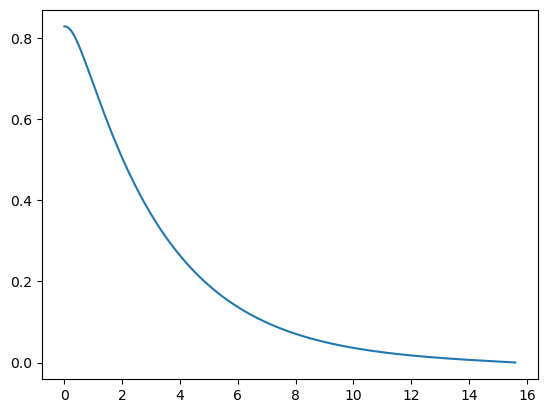

In [9]:
plt.plot(time, C_Phi_T)

In [ ]:
equation_2_14(d, g=2)

In [ ]:
time, Delta_T, Delta_T_dot = solve_for_Delta_T(g=2, Delta_0=d, T=20, dT=0.03)

In [ ]:
plt.plot(time, Delta_T)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'theory'
job_name = 'g_dz_theory'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
job_id_1 = submit_job(job_script_path, n_jobs)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
for i in range(100):
    path = '../results/misc/g_dz_theory/result_{}'.format(i)
    with open(path, 'rb') as f:
        result = pickle.load(f)
    result['processed_data'] = np.array([0, 0])
    with open(path, 'wb') as f:
        f = pickle.dump(result, f)

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'g_dz_theory'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
configs_array

In [ ]:
dz_values=[0.03, 0.01, 0.003, 0.001]
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
for key in sim_dict:
    i_col = configs_array['dz'].index(float(key.split('_')[1]))
    i_g = configs_array['g'].index(float(key.split('_')[0]))
    ax[i_col].plot(sim_dict[key]['lags'], sim_dict[key]['Delta_T'], color='C{}'.format(i_g), alpha=0.2)
    ax[i_col].set_xticks([0, 10, 20])
    ax[i_col].set_xlabel('tau')
    ax[i_col].set_ylabel('$\Delta(tau)$')
fig.savefig('figs/g_dz.pdf', format='pdf')

In [ ]:
dz_values=[0.03, 0.01, 0.003, 0.001]
fig = plt.figure(figsize=(10, 10))
for key in sim_dict:
    i_col = configs_array['dz'].index(float(key.split('_')[1]))
    i_g = configs_array['g'].index(float(key.split('_')[0]))
    plt.plot(sim_dict[key]['lags'], sim_dict[key]['Delta_T'], color='C{}'.format(i_g), alpha=0.2)
    plt.xticks([0, 10, 20])
    plt.xlabel('$tau$')
    plt.ylabel('$\Delta(tau)$')
fig.savefig('figs/g_dz_all.pdf', format='pdf')

In [ ]:
theory = []
for g in configs_array['g']:
    theory.append(solve_for_Delta_0(g))
#plt.plot(configs_array['g'], theory, color='k')
for i in range(len(configs_array['n'])):
    plt.figure()
    plt.plot(configs_array['g'], theory, color='k')
    for j in range(len(configs_array['i_seed'])):
        plt.plot(configs_array['g'], results_array[i, :, j], '.', color='C{}'.format(i))
        

In [ ]:
def plot_2d_array_of_time_series(configs_array, results_array, common_ylim=None):
    
    n_x, n_y, n_seeds, n_t = results_array.shape[:]
    keys = [key for key in configs_array.keys()]
    fig, ax = plt.subplots(n_x, n_y, figsize=(10,10))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_seeds):
                ax[i, j].plot(results_array[i,j,k,:], color='C0')
            if common_ylim is not None:
                ax[i, j].set_ylim(common_ylim)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[0, j].set_title('{} = {}'.format(keys[1], configs_array[keys[1]][j]))
            ax[i, 0].set_ylabel('{} = {}'.format(keys[0], configs_array[keys[0]][i]))

In [ ]:
plot_2d_array_of_time_series(configs_array, results_array)

In [ ]:
results_array.shape
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    for j in range(3):
        for k in range(5):
            ax[i,j].plot(results_array[i,j,k,::100], color='C0')
            #ax[i,j].set_ylim([-0.01, 0.01])

#fig.savefig('figs/n_ginit.pdf', format='pdf')

In [ ]:
### --- Plot examples with one task --- ###
task = Flip_Flop_Task(3, 0.05)
data = task.gen_data(1000, 1000) #generate data from task
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array,
                                             key_order, sim_dict, data=data,
                                             task_dict=None, N_task_data=1000,
                                             xlim=20, trace_spacing=3)

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order,
                                            tick_rounding=5, vmin=0, vmax=0.9)